<a href="https://colab.research.google.com/github/2303A51795/REINFORCEMENT-LEARNING-BATCH12-2303A51795/blob/main/LAB_TEST_1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Drone delivery MDP with wind and battery constraints — Value Iteration
# This code builds a small MDP for a drone that must deliver parcels to 3 locations.
# It models stochastic wind that sometimes increases battery consumption when flying.
# We solve the MDP with Value Iteration and print the optimal policy and value for the
# starting state (at base, all parcels undelivered, full battery).
#
# You can run and modify parameters (battery capacity, wind probabilities, rewards)
# to explore different behaviors.

from itertools import product
import numpy as np
import pandas as pd

# ----- MDP parameters -----
LOCATIONS = {0: "Base", 1: "Loc1", 2: "Loc2", 3: "Loc3"}
NUM_LOC = len(LOCATIONS)  # includes base as 0
PARCELS = [1, 2, 3]  # parcels correspond to locations 1..3
MAX_BATTERY = 3  # discrete battery levels: 0..MAX_BATTERY
DISCOUNT = 0.95

# Rewards / costs
REWARD_DELIVER = 100.0
COST_PER_STEP = -1.0
COST_RECHARGE = -2.0
FAILURE_PENALTY = -100.0

# Wind model: for each route (from,to) probability that wind will cause extra consumption
# We can make wind stronger when flying between some locations; base -> others moderate.
# Values in [0,1].
WIND_PROB = {}
for i in LOCATIONS:
    for j in LOCATIONS:
        if i == j:
            WIND_PROB[(i, j)] = 0.0
        else:
            # example pattern: slightly higher wind when crossing between non-base locations
            if i == 0 or j == 0:
                WIND_PROB[(i, j)] = 0.15
            else:
                WIND_PROB[(i, j)] = 0.30

# Actions:
# - "fly_X" where X is 0..3 (destination)
# - "deliver" available only when at that delivery location and the parcel remains
# - "recharge" available only at base and restores battery to MAX_BATTERY
def actions_for_state(state):
    loc, parcels_mask, b = state
    acts = []
    # deliver if at delivery location and parcel present
    if loc != 0:
        parcel_idx = loc - 1  # parcel index 0..2
        if (parcels_mask >> parcel_idx) & 1:
            acts.append("deliver")
    # recharge if at base and battery not full
    if loc == 0 and b < MAX_BATTERY:
        acts.append("recharge")
    # fly to any other location (including base)
    for dest in LOCATIONS:
        if dest != loc:
            acts.append(f"fly_{dest}")
    return acts

# State space generation
states = []
state_to_idx = {}
idx = 0
for loc in LOCATIONS:
    for parcels_mask in range(0, 1 << len(PARCELS)):  # bitmask of remaining parcels; 1 means undelivered
        for b in range(0, MAX_BATTERY + 1):
            s = (loc, parcels_mask, b)
            states.append(s)
            state_to_idx[s] = idx
            idx += 1

N = len(states)
print(f"Number of states: {N}")

# Terminal function
def is_terminal(state):
    loc, parcels_mask, b = state
    # success: all parcels delivered
    if parcels_mask == 0:
        return True
    # failure: battery == 0 and not at base (stuck)
    if b == 0 and loc != 0:
        return True
    return False

# Transition model: returns list of (prob, next_state, reward, done)
def transitions(state, action):
    loc, parcels_mask, b = state
    if is_terminal(state):
        return [(1.0, state, 0.0, True)]
    # common cost per step for actions that take time
    if action.startswith("fly_"):
        dest = int(action.split("_")[1])
        # two possible outcomes: normal consumption (1 battery) or extra consumption (2 batteries) due to wind
        p_wind = WIND_PROB[(loc, dest)]
        outcomes = []
        for extra in (0, 1):  # extra 0 means normal (consume 1), extra=1 means wind (consume 2)
            prob = p_wind if extra == 1 else (1 - p_wind)
            consume = 1 + extra
            b_next = max(0, b - consume)
            next_loc = dest
            next_parcels = parcels_mask
            reward = COST_PER_STEP  # time/cost for flying
            done = False
            # If battery hits zero and not at base -> failure
            if b_next == 0 and next_loc != 0:
                reward += FAILURE_PENALTY
                done = True
            # If after flying we have delivered nothing; deliveries only happen with "deliver" action
            outcomes.append((prob, (next_loc, next_parcels, b_next), reward, done))
        return outcomes
    elif action == "deliver":
        # deliver consumes negligible battery but gives reward and clears parcel bit
        parcel_idx = loc - 1
        if parcel_idx < 0:
            # invalid deliver at base: no-op
            return [(1.0, state, -1.0, False)]
        if ((parcels_mask >> parcel_idx) & 1) == 0:
            # already delivered: small penalty for pointless action
            return [(1.0, state, -1.0, False)]
        next_parcels = parcels_mask & ~(1 << parcel_idx)
        reward = REWARD_DELIVER + COST_PER_STEP  # reward minus time cost
        next_state = (loc, next_parcels, b)
        done = next_parcels == 0
        return [(1.0, next_state, reward, done)]
    elif action == "recharge":
        # recharge consumes time but restores battery
        next_state = (loc, parcels_mask, MAX_BATTERY)
        reward = COST_RECHARGE
        done = False
        return [(1.0, next_state, reward, done)]
    else:
        # invalid action -> no-op
        return [(1.0, state, -1.0, False)]

# Build policy/value containers and perform value iteration
V = np.zeros(N)
policy = [None] * N

def value_iteration(theta=1e-4, max_iters=10000):
    global V, policy
    it = 0
    while True:
        delta = 0.0
        for i, s in enumerate(states):
            if is_terminal(s):
                V[i] = 0.0
                policy[i] = None
                continue
            acts = actions_for_state(s)
            best_a_val = -1e9
            best_a = None
            for a in acts:
                q = 0.0
                for prob, s_next, r, done in transitions(s, a):
                    j = state_to_idx[s_next]
                    q += prob * (r + (0.0 if done else DISCOUNT * V[j]))
                if q > best_a_val:
                    best_a_val = q
                    best_a = a
            if best_a is None:
                best_a_val = 0.0
            delta = max(delta, abs(V[i] - best_a_val))
            V[i] = best_a_val
            policy[i] = best_a
        it += 1
        if delta < theta or it >= max_iters:
            break
    return it

iters = value_iteration()
print(f"Value iteration converged in {iters} iterations.")

# Helper to pretty-print a policy for a subset of states
def describe_state(s):
    loc, parcels_mask, b = s
    parcels = []
    for idx_p, p in enumerate(PARCELS):
        if (parcels_mask >> idx_p) & 1:
            parcels.append(f"P{idx_p+1}")
    parcels_str = ",".join(parcels) if parcels else "None"
    return f"Loc={LOCATIONS[loc]:5s} | Parcels={parcels_str:8s} | Batt={b}"

# Show the policy and value for the starting state (Base, all parcels present, full battery)
start_state = (0, (1<<len(PARCELS)) - 1, MAX_BATTERY)
start_idx = state_to_idx[start_state]
print("\nStart state:")
print(describe_state(start_state))
print(f"Optimal action: {policy[start_idx]}")
print(f"Value: {V[start_idx]:.2f}")

# Show top states by value (most valuable non-terminal states)
rows = []
for i, s in enumerate(states):
    if is_terminal(s):
        continue
    rows.append({"State": describe_state(s), "Action": policy[i], "Value": V[i]})# Show top states by value (most valuable non-terminal states)
rows = []
for i, s in enumerate(states):
    if is_terminal(s):
        continue
    rows.append({"State": describe_state(s), "Action": policy[i], "Value": V[i]})
df = pd.DataFrame(rows)
df_sorted = df.sort_values("Value", ascending=False).head(12).reset_index(drop=True)

print("\nTop 12 states by value:")
print(df_sorted.to_string(index=False))

# Also print a few illustrative states manually
print("\nTop 8 states (text):")
for r in df_sorted.itertuples(index=False):
    print(f"{r.State}  -> Action: {r.Action:10s}  Value: {r.Value:.2f}")

# Save a small policy table for reference
policy_table = []
for s_idx, s in enumerate(states):
    policy_table.append((s, policy[s_idx], V[s_idx]))
# Keep only a manageable subset for viewing: states with battery full
subset = [entry for entry in policy_table if entry[0][2] == MAX_BATTERY][:20]
pd_subset = pd.DataFrame([{"State": describe_state(e[0]), "Action": e[1], "Value": e[2]} for e in subset])

print("\nSample policy (battery full, first 20 states):")
print(pd_subset.to_string(index=False))


Number of states: 128
Value iteration converged in 8 iterations.

Start state:
Loc=Base  | Parcels=P1,P2,P3 | Batt=3
Optimal action: fly_1
Value: 225.82

Top 12 states by value:
                                State   Action      Value
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Base  | Parcels=P1,P2,P3 | Batt=3    fly_1 225.822061
Loc=Base  | Parcels=P1,P2,P3 | Batt=1 recharge 212.530958
Loc=Base  | Parcels=P1,P2,P3 | Batt=0 recharge 212.530958

Top 8 states (text):
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=3  -> Acti

In [4]:
import numpy as np, pandas as pd
from itertools import product

# --- Parameters ---
LOCATIONS = {0: "Base", 1: "Loc1", 2: "Loc2", 3: "Loc3"}
PARCELS, MAX_BATTERY, DISCOUNT = [1, 2, 3], 3, 0.95
REWARD_DELIVER, COST_PER_STEP, COST_RECHARGE, FAILURE_PENALTY = 100.0, -1.0, -2.0, -100.0

# Wind probabilities
WIND_PROB = {(i, j): 0.0 if i == j else 0.15 if 0 in (i, j) else 0.30 for i in LOCATIONS for j in LOCATIONS}

# --- State & Action Space ---
states, state_to_idx = [], {}
for loc, parcels_mask, b in product(LOCATIONS, range(1 << len(PARCELS)), range(MAX_BATTERY + 1)):
    s = (loc, parcels_mask, b)
    state_to_idx[s] = len(states)
    states.append(s)
N = len(states)

def is_terminal(s):
    loc, parcels_mask, b = s
    return parcels_mask == 0 or (b == 0 and loc != 0)

def actions_for_state(s):
    loc, parcels_mask, b = s
    acts = [f"fly_{d}" for d in LOCATIONS if d != loc]
    if loc != 0 and (parcels_mask >> (loc - 1)) & 1: acts.append("deliver")
    if loc == 0 and b < MAX_BATTERY: acts.append("recharge")
    return acts

def transitions(s, a):
    loc, parcels_mask, b = s
    if is_terminal(s): return [(1.0, s, 0.0, True)]
    if a.startswith("fly_"):
        dest = int(a.split("_")[1])
        p_wind = WIND_PROB[(loc, dest)]
        return [(p_wind if e else 1 - p_wind,
                 (dest, parcels_mask, max(0, b - (1 + e))),
                 COST_PER_STEP + (FAILURE_PENALTY if max(0, b - (1 + e)) == 0 and dest != 0 else 0),
                 max(0, b - (1 + e)) == 0 and dest != 0)
                for e in (0, 1)]
    if a == "deliver":
        idx = loc - 1
        if idx < 0 or not (parcels_mask >> idx) & 1:
            return [(1.0, s, -1.0, False)]
        new_mask = parcels_mask & ~(1 << idx)
        return [(1.0, (loc, new_mask, b), REWARD_DELIVER + COST_PER_STEP, new_mask == 0)]
    if a == "recharge":
        return [(1.0, (loc, parcels_mask, MAX_BATTERY), COST_RECHARGE, False)]
    return [(1.0, s, -1.0, False)]

# --- Value Iteration ---
V, policy = np.zeros(N), [None] * N
def value_iteration(theta=1e-4, max_iters=10000):
    for it in range(max_iters):
        delta = 0
        for i, s in enumerate(states):
            if is_terminal(s): continue
            best_val, best_act = max(
                ((sum(p * (r + (0 if d else DISCOUNT * V[state_to_idx[ns]]))
                      for p, ns, r, d in transitions(s, a)), a)
                 for a in actions_for_state(s)),
                key=lambda x: x[0], default=(0.0, None))
            delta = max(delta, abs(V[i] - best_val))
            V[i], policy[i] = best_val, best_act
        if delta < theta: return it + 1
    return max_iters

iters = value_iteration()
print(f"Value iteration converged in {iters} iterations.")

def describe_state(s):
    loc, mask, b = s
    parcels = ",".join(f"P{p}" for p in PARCELS if (mask >> (p - 1)) & 1) or "None"
    return f"Loc={LOCATIONS[loc]:5s} | Parcels={parcels:8s} | Batt={b}"

# --- Results ---
start_state = (0, (1 << len(PARCELS)) - 1, MAX_BATTERY)
start_idx = state_to_idx[start_state]
print("\nStart state:")
print(describe_state(start_state))
print(f"Optimal action: {policy[start_idx]}")
print(f"Value: {V[start_idx]:.2f}")

rows = [{"State": describe_state(s), "Action": policy[i], "Value": V[i]}
        for i, s in enumerate(states) if not is_terminal(s)]
df = pd.DataFrame(rows).sort_values("Value", ascending=False).head(12).reset_index(drop=True)

print("\nTop 12 states by value:")
print(df.to_string(index=False))

print("\nTop 8 states (text):")
for r in df.itertuples(index=False):
    print(f"{r.State}  -> Action: {r.Action:10s}  Value: {r.Value:.2f}")

subset = [(s, policy[i], V[i]) for i, s in enumerate(states) if s[2] == MAX_BATTERY][:20]
df_subset = pd.DataFrame([{"State": describe_state(s), "Action": a, "Value": v} for s, a, v in subset])

print("\nSample policy (battery full, first 20 states):")
print(df_subset.to_string(index=False))

Value iteration converged in 8 iterations.

Start state:
Loc=Base  | Parcels=P1,P2,P3 | Batt=3
Optimal action: fly_1
Value: 225.82

Top 12 states by value:
                                State   Action      Value
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=3  deliver 256.911429
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Loc2  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc1  | Parcels=P1,P2,P3 | Batt=1  deliver 238.760064
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=2  deliver 238.760064
Loc=Base  | Parcels=P1,P2,P3 | Batt=3    fly_1 225.822061
Loc=Base  | Parcels=P1,P2,P3 | Batt=1 recharge 212.530958
Loc=Base  | Parcels=P1,P2,P3 | Batt=0 recharge 212.530958

Top 8 states (text):
Loc=Loc3  | Parcels=P1,P2,P3 | Batt=3  -> Action: deliver     Value:

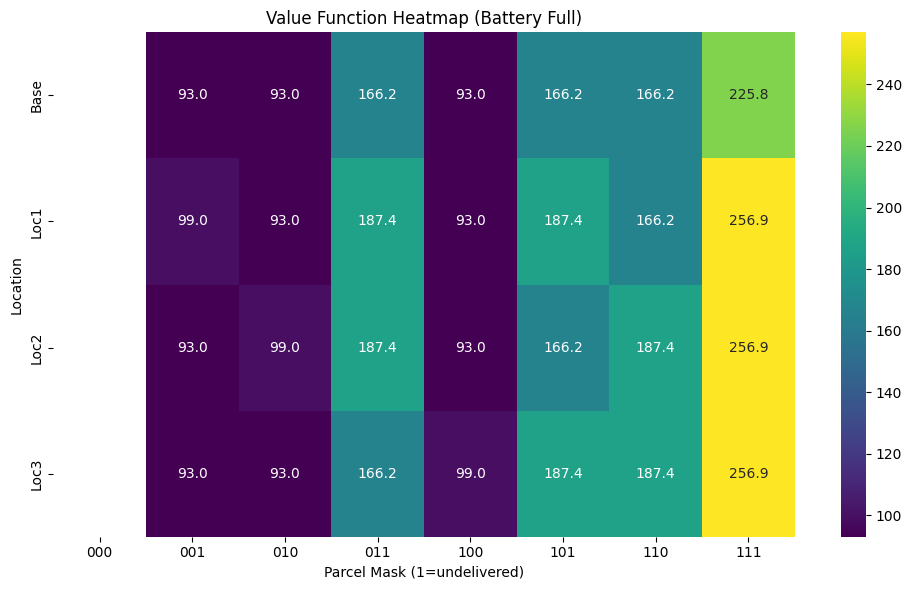

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare heatmap data: rows = locations, cols = parcel masks
heatmap_data = np.full((len(LOCATIONS), 1 << len(PARCELS)), np.nan)

for s in states:
    loc, mask, batt = s
    if batt == MAX_BATTERY and not is_terminal(s):
        idx = state_to_idx[s]
        heatmap_data[loc][mask] = V[idx]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=[bin(m)[2:].zfill(len(PARCELS)) for m in range(1 << len(PARCELS))],
            yticklabels=[LOCATIONS[i] for i in range(len(LOCATIONS))])
plt.title("Value Function Heatmap (Battery Full)")
plt.xlabel("Parcel Mask (1=undelivered)")
plt.ylabel("Location")
plt.tight_layout()
plt.show()